## Modelagem de Dispersão
Neste notebook vamos implementar um modelo de dispersão Gaussiano 


Primeiro criamos um data frame com as datas do ano, mes, dia e hora, para que fosse possível criar valores aleatório para radiação, cobertura de nuvens e velocidade do vento, os quais variam para cada hora durante o ano de 2023. 


In [258]:
import pandas as pd
import numpy as np

# Gerar um intervalo de datas para o ano de 2023
datas = pd.date_range(start='2023-01-01', end='2023-12-31', freq='D')

# Criar DataFrame com as datas
df = pd.DataFrame({'Data': datas})

# Extrair os meses das datas e adicioná-los como uma nova coluna no DataFrame
df['Mes'] = df['Data'].dt.month

# Extrair o dia do ano das datas e adicioná-lo como uma nova coluna no DataFrame
df['Dia_do_Ano'] = df['Data'].dt.dayofyear

# Expandir as datas para incluir as horas do dia (1 a 24)
df_expandido = df.loc[df.index.repeat(24)].reset_index(drop=True)
df_expandido['Hora_Dia'] = [hora for _ in range(len(df)) for hora in range(1, 25)]



In [259]:
# Parâmetros de aleatoriedade para radiação, cobertura de nuvens e velocidade do vento
radMax = 1000
radMin = 1

cobertura_de_nuvensMax = 100
cobertura_de_nuvensMin = 0

veloc_ventoMax = 11.31
veloc_ventoMin = 0

# Número de linhas/número de datas
n = df_expandido.shape[0]

# Criar valores aleatórios
radiacao = (radMax - radMin) * np.random.rand(n) + radMin
cobertura_de_nuvens = (cobertura_de_nuvensMax - cobertura_de_nuvensMin) * np.random.rand(n) + cobertura_de_nuvensMin
veloc_vento = (veloc_ventoMax - veloc_ventoMin) * np.random.rand(n) + veloc_ventoMin

# Adicionar as colunas ao DataFrame
df_expandido['Radiacao'] = radiacao
df_expandido['Cobertura_de_Nuvens'] = cobertura_de_nuvens
df_expandido['Veloc_Vento'] = veloc_vento
df_expandido


,Data,Mes,Dia_do_Ano,Hora_Dia,Radiacao,Cobertura_de_Nuvens,Veloc_Vento
0,2023-01-01,1,1,1,741.442901,18.010906,4.960227
1,2023-01-01,1,1,2,78.994322,98.126019,8.719381
2,2023-01-01,1,1,3,534.239966,43.716993,10.032631
3,2023-01-01,1,1,4,326.774417,73.357837,6.816328
4,2023-01-01,1,1,5,921.595904,91.157905,1.184020
...,...,...,...,...,...,...,...
8755,2023-12-31,12,365,20,829.418519,47.021369,0.710479
8756,2023-12-31,12,365,21,407.416155,36.952951,2.959535
8757,2023-12-31,12,365,22,335.747560,69.582559,5.774498
8758,2023-12-31,12,365,23,755.880320,72.148190,5.733963


## 1. Implementar uma função para determinar a classe de estabilidade de Pasquil para diferentes condições atmosféricas

In [260]:
# Função para determinar a classe de estabilidade
def classe_estabilidade(hora_dia, radiacao, cobertura_de_nuvens, veloc_vento):
    if hora_dia < 6 or hora_dia >= 18:
        # Condições noturnas
        if cobertura_de_nuvens >= 5:
            if 2 <= veloc_vento <= 3:
                return "E"
            else:
                return "D"
        else:
            if 2 <= veloc_vento < 3:
                return "F"
            elif 3 <= veloc_vento <= 5:
                return "E"
            else:
                return "D"
    else:
        # Condições diurnas
        if radiacao > 700:  # Radiação solar forte
            if veloc_vento < 2:
                return "A"
            elif 2 <= veloc_vento <= 5:
                return "B"
            else:
                return "C"
        elif 350 <= radiacao <= 700:  # Radiação solar moderada
            if veloc_vento < 3:
                return "B"
            elif 3 < veloc_vento <= 5:
                return "C"
            else:
                return "D"
        else:  # Radiação solar fraca
            if veloc_vento < 2:
                return "B"
            elif 2 <= veloc_vento <= 3:
                return "C"
            elif 3 < veloc_vento <= 5:
                return "C"
            elif 5 < veloc_vento <= 6:
                return "C"
            else:
                return "D"

# Aplicar a função para cada linha do DataFrame
df_expandido['Classe_Estabilidade'] = df_expandido.apply(
    lambda row: classe_estabilidade(
        row['Hora_Dia'],
        row['Radiacao'],
        row['Cobertura_de_Nuvens'],
        row['Veloc_Vento']
    ), axis=1
)

# Verificar o DataFrame expandido
print(df_expandido)

# Salvar o DataFrame em um arquivo CSV
df_expandido.to_csv(r'C:\Users\Carlos Suganuma - VB\Documents\GitHub\ENS5173_202401\tabelas\estabilidade.csv')


           Data  Mes  Dia_do_Ano  Hora_Dia    Radiacao  Cobertura_de_Nuvens  \
0    2023-01-01    1           1         1  741.442901            18.010906   
1    2023-01-01    1           1         2   78.994322            98.126019   
2    2023-01-01    1           1         3  534.239966            43.716993   
3    2023-01-01    1           1         4  326.774417            73.357837   
4    2023-01-01    1           1         5  921.595904            91.157905   
...         ...  ...         ...       ...         ...                  ...   
8755 2023-12-31   12         365        20  829.418519            47.021369   
8756 2023-12-31   12         365        21  407.416155            36.952951   
8757 2023-12-31   12         365        22  335.747560            69.582559   
8758 2023-12-31   12         365        23  755.880320            72.148190   
8759 2023-12-31   12         365        24   42.017299            91.065336   

      Veloc_Vento Classe_Estabilidade  
0        4.

## 2. Implementar a função de estimativa de coefiente de dispersão (sigmaYZ) para todas as classes de estabilidade

In [261]:
# Criando função da estimativa da dispersão lateral e vertical da pluma
# Fórmulação de Brigs, classe Pasquil

# Cria uma lista de valores de 0 a 50000 em incrementos de 1000
x_values = list(np.arange(0, 50001, 1000))
x_values[0] = 1
# Função da estimativa da dispersão lateral e vertical da pluma
def sigmaYZ(classe, x, urbOrRural):
    if urbOrRural == 'urbano':
        if classe in ['A', 'B']:
            sigmaY = 0.32 * x * (1 + 0.0004 * x) ** (-0.5)
            sigmaZ = 0.24 * x * (1 + 0.001 * x) ** (0.5)
        elif classe == 'C':
            sigmaY = 0.22 * x * (1 + 0.0004 * x) ** (-0.5)
            sigmaZ = 0.20 * x
        elif classe == 'D':
            sigmaY = 0.16 * x * (1 + 0.0004 * x) ** (-0.5)
            sigmaZ = 0.14 * x * (1 + 0.0003 * x) ** (-0.5)
        elif classe in ['E', 'F']:
            sigmaY = 0.11 * x * (1 + 0.0004 * x) ** (-0.5)
            sigmaZ = 0.08 * x * (1 + 0.0015 * x) ** (-0.5)
        else:
            raise ValueError('Classe de estabilidade errada')
    elif urbOrRural == 'rural':
        if classe == 'A':
            sigmaY = 0.22 * x * (1 + 0.0001 * x) ** (-0.5)
            sigmaZ = 0.20 * x
        elif classe == 'B':
            sigmaY = 0.16 * x * (1 + 0.0001 * x) ** (-0.5)
            sigmaZ = 0.12 * x
        elif classe == 'C':
            sigmaY = 0.11 * x * (1 + 0.0001 * x) ** (-0.5)
            sigmaZ = 0.08 * x * (1 + 0.0002 * x) ** (-0.5)
        elif classe == 'D':
            sigmaY = 0.08 * x * (1 + 0.0001 * x) ** (-0.5)
            sigmaZ = 0.06 * x * (1 + 0.0015 * x) ** (-0.5)
        elif classe == 'E':
            sigmaY = 0.06 * x * (1 + 0.0001 * x) ** (-0.5)
            sigmaZ = 0.03 * x * (1 + 0.0003 * x) ** (-1)
        elif classe == 'F':
            sigmaY = 0.04 * x * (1 + 0.0001 * x) ** (-0.5)
            sigmaZ = 0.016 * x * (1 + 0.0003 * x) ** (-1)
        else:
            raise ValueError('Classe de estabilidade errada. Fique ligado')
    else:
        raise ValueError('Tipo de área errada')
    return sigmaY, sigmaZ

# Define o tipo de área
urbOrRural = 'urbano'
sY = np.zeros((df_expandido.Classe_Estabilidade.shape[0],len(x_values)))
sZ = np.zeros((df_expandido.Classe_Estabilidade.shape[0],len(x_values)))
for ii in range(0,df_expandido.Classe_Estabilidade.shape[0]):
    for jj in range (0, len(x_values)):
        sigmaY,sigmaZ = sigmaYZ(df_expandido.Classe_Estabilidade[ii],x_values[jj],urbOrRural)
        sY[ii,jj]=sigmaY
        sZ[ii,jj]=sigmaZ


In [262]:
# Geração das colunas sigmaY e sigmaZ
for x in x_values:
    sigmaY = []
    sigmaZ = []
    for i in range(df_expandido.shape[0]):
        sigmaY_i, sigmaZ_i = sigmaYZ(df_expandido.loc[i, 'Classe_Estabilidade'], x, urbOrRural)
        sigmaY.append(sigmaY_i)
        sigmaZ.append(sigmaZ_i)
    df_expandido[f'sigmaY_{x}'] = sigmaY
    df_expandido[f'sigmaZ_{x}'] = sigmaZ

C:\Users\Carlos Suganuma - VB\AppData\Local\Temp\ipykernel_1300\2617540073.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_expandido[f'sigmaZ_{x}'] = sigmaZ
C:\Users\Carlos Suganuma - VB\AppData\Local\Temp\ipykernel_1300\2617540073.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_expandido[f'sigmaY_{x}'] = sigmaY
C:\Users\Carlos Suganuma - VB\AppData\Local\Temp\ipykernel_1300\2617540073.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which

In [263]:
print(df_expandido)
#Salvar o DataFrame em um arquivo CSV
#df_expandido.to_csv(r'C:\Users\BiaBN\OneDrive\Documentos\controledepoluicaoatm\tabelas\estabilidade.csv')

           Data  Mes  Dia_do_Ano  Hora_Dia    Radiacao  Cobertura_de_Nuvens  \
0    2023-01-01    1           1         1  741.442901            18.010906   
1    2023-01-01    1           1         2   78.994322            98.126019   
2    2023-01-01    1           1         3  534.239966            43.716993   
3    2023-01-01    1           1         4  326.774417            73.357837   
4    2023-01-01    1           1         5  921.595904            91.157905   
...         ...  ...         ...       ...         ...                  ...   
8755 2023-12-31   12         365        20  829.418519            47.021369   
8756 2023-12-31   12         365        21  407.416155            36.952951   
8757 2023-12-31   12         365        22  335.747560            69.582559   
8758 2023-12-31   12         365        23  755.880320            72.148190   
8759 2023-12-31   12         365        24   42.017299            91.065336   

      Veloc_Vento Classe_Estabilidade  sigmaY_1  si

## 3. Implementar a função de estimativa de sobrelevação da pluma utilizando os métodos de Davidson-Bryant, Holland e Briggs. Deve ser considerado o efeito Tip-Downwash

In [264]:
# Função para estimar o deltaH com base na equação de Davidson-Bryant
def deltaHdavidsonBryant(d,vs,u,Ts,Tamb):
    deltaH = (d*(vs/u)**(1.4))*(1+(Ts-Tamb)/Ts)
    return deltaH

In [265]:
# Função para estimar o deltaH com base na equação de Holland
def deltaHHolland(d,vs,u,p,Ts,Tamb):
    deltaH = ((vs*d/u)*(1.5+2.68*10^(-3)*p*(Ts-Tamb)*d/Ts))
    return deltaH

In [266]:
# Função para estimar o deltaH com base na equação de Briggs
def deltaHBriggs(d,vs,Ts,Tamb,classe,u):
    Fb = 9.8*((d/2)**2)*vs*(1-Tamb/Ts)
    if classe == 'A':
        gradT = -0.02 + 0.0098
    elif classe == 'B':
        gradT = -0.018 + 0.0098 
    elif classe == 'C':
        gradT = -0.016 + 0.0098 
    elif classe == 'D':
        gradT = -0.01 + 0.0098 
    elif classe == 'E':
        gradT = 0.005 + 0.0098 
    elif classe == 'F':
        gradT = 0.028 + 0.0098 
    else:
        print('Classe de estabilidade errada')
    s = (9.8/Tamb)*(gradT)
    if classe == 'A' or classe == 'B' or classe == 'C' or classe == 'D':
        if Fb < 55:
            deltaTc = 0.0297*Ts*(vs**(1/3))/(d**(2/3))
            if (Ts - Tamb) < deltaTc:
                deltaH = 3*d*vs/u
            else:
                deltaH = 21.425*Fb**(3/4)/u
        else:
            deltaTc = 0.0057*Ts*(vs**(2/3)/d**(1/3))
            if (Ts - Tamb) < deltaTc:
                deltaH = 3*d*vs/u
            else:
                deltaH = 2.6*(Fb/(u*s))**(1/3)
    elif classe == 'E' or classe == 'F':
        deltaTc = 0.019582*Ts*vs*s**(1/2)
        if (Ts - Tamb) < deltaTc:
            Fm = (vs**2)*(d**2)*Tamb/(4*Ts) 
            deltaH1 = 1.5*(Fm/(u*s**(1/2)))**(1/3)
            deltaH2 = 3*d*vs/u
            if deltaH1 > deltaH2:
                deltaH = deltaH2
            else:
                deltaH = deltaH1
        else:
            deltaH = 2.6*(Fb/(u*s))**(1/3)
    return deltaH

## Utilizando o modelo de Briggs para calcular deltaH

In [267]:
d = 1 #diametro da chaminé
vs = 20 #velociadade na saida da chaminé
Ts = 400 # em Kelvin
Tamb = 293 # em Kelvin

dH = np.zeros((df_expandido.Classe_Estabilidade.shape[0]))
for ii in range(0,df_expandido.Classe_Estabilidade.shape[0]):
    deltaH = deltaHBriggs(d,vs,Ts,Tamb,df_expandido.Classe_Estabilidade[ii],df_expandido.Veloc_Vento[ii])
    dH[ii] = deltaH
df_expandido['deltaH'] = dH
print(df_expandido)

           Data  Mes  Dia_do_Ano  Hora_Dia    Radiacao  Cobertura_de_Nuvens  \
0    2023-01-01    1           1         1  741.442901            18.010906   
1    2023-01-01    1           1         2   78.994322            98.126019   
2    2023-01-01    1           1         3  534.239966            43.716993   
3    2023-01-01    1           1         4  326.774417            73.357837   
4    2023-01-01    1           1         5  921.595904            91.157905   
...         ...  ...         ...       ...         ...                  ...   
8755 2023-12-31   12         365        20  829.418519            47.021369   
8756 2023-12-31   12         365        21  407.416155            36.952951   
8757 2023-12-31   12         365        22  335.747560            69.582559   
8758 2023-12-31   12         365        23  755.880320            72.148190   
8759 2023-12-31   12         365        24   42.017299            91.065336   

      Veloc_Vento Classe_Estabilidade  sigmaY_1  si

C:\Users\Carlos Suganuma - VB\AppData\Local\Temp\ipykernel_1300\1391082514.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_expandido['deltaH'] = dH


## 4. Implementar a função do modelo gaussiano

In [268]:
# Criando uma função do modelo gaussiano
import numpy as np
def modeloGaussiano(qs,sigmaY,sigmaZ,u,y,z,H):
    termo1 = qs/(2*np.pi*sigmaY*sigmaZ*u)
    termo2 = np.exp((-y**2)/(2*sigmaY**2))
    termo3 = np.exp((-(z-H)**2)/(2*sigmaZ**2)) + np.exp((-(z+H)**2)/(2*sigmaZ**2))
    conc = termo1*termo2*termo3
    conc = conc*10**6
    return conc

## 5. Realizar simulações com o script criado, utilizando diferentes classes de estabilidade, velocidades do vento, alturas de chaminé. Considere a taxa de emissão que você estimou na primeira atividade. Encontre a altura de chaminé necessária para que as concentrações não violem os padrões da Resolução CONAMA 491

In [269]:
# Estimando a sobrelevação da pluma (deltaH)
hg = 100 #altura da chaminé
Hefetiva = np.zeros((df_expandido.Classe_Estabilidade.shape[0]))

for ii in range(0,df_expandido.Classe_Estabilidade.shape[0]):
    if vs>1.5*(df_expandido['Veloc_Vento'][ii]):
        Hefetiva[ii] = hg+(df_expandido['deltaH'][ii])
    else:
        Hefetiva[ii] = hg +2*d*((vs/u)-1.5)
df_expandido['Hefetiva'] = Hefetiva
print(df_expandido)

           Data  Mes  Dia_do_Ano  Hora_Dia    Radiacao  Cobertura_de_Nuvens  \
0    2023-01-01    1           1         1  741.442901            18.010906   
1    2023-01-01    1           1         2   78.994322            98.126019   
2    2023-01-01    1           1         3  534.239966            43.716993   
3    2023-01-01    1           1         4  326.774417            73.357837   
4    2023-01-01    1           1         5  921.595904            91.157905   
...         ...  ...         ...       ...         ...                  ...   
8755 2023-12-31   12         365        20  829.418519            47.021369   
8756 2023-12-31   12         365        21  407.416155            36.952951   
8757 2023-12-31   12         365        22  335.747560            69.582559   
8758 2023-12-31   12         365        23  755.880320            72.148190   
8759 2023-12-31   12         365        24   42.017299            91.065336   

      Veloc_Vento Classe_Estabilidade  sigmaY_1  si

C:\Users\Carlos Suganuma - VB\AppData\Local\Temp\ipykernel_1300\2895479443.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_expandido['Hefetiva'] = Hefetiva


In [274]:
# Parâmetros do modelo, utilizando como qs a emissão máxima (calculada na atividade 1) de cada poluente
qsMP = 320.65 # g/s
qsSO2 = 0.55    # g/s
qsCO = 12.67   # g/s
y = 0             # estimando na direção do vento
z = 1.5           # altura do nariz
H = 50            # m
urbOrRural = 'urbano'

# Inicializa listas para concentrações
concMP = np.zeros((df_expandido.shape[0], len(x_values)))
concSO2 = np.zeros((df_expandido.shape[0], len(x_values)))
concCO = np.zeros((df_expandido.shape[0], len(x_values)))

# Calcular concentrações para cada linha do DataFrame
for i in range(df_expandido.shape[0]):
    u = df_expandido.loc[i, 'Veloc_Vento']
    H_efetiva = df_expandido.loc[i, 'Hefetiva']
    
    for j, x in enumerate(x_values):
        sigmaY = df_expandido.loc[i, f'sigmaY_{x}']
        sigmaZ = df_expandido.loc[i, f'sigmaZ_{x}']
        
        concMP[i, j] = modeloGaussiano(qsMP, sigmaY, sigmaZ, u, y, z, H_efetiva)
        concSO2[i, j] = modeloGaussiano(qsSO2, sigmaY, sigmaZ, u, y, z, H_efetiva)
        concCO[i, j] = modeloGaussiano(qsCO, sigmaY, sigmaZ, u, y, z, H_efetiva)

# Adiciona colunas de concentrações ao DataFrame para todas as distâncias x_values
for j, x in enumerate(x_values):
    df_expandido[f'concMP_{x}'] = concMP[:, j]
    df_expandido[f'concSO2_{x}'] = concSO2[:, j]
    df_expandido[f'concCO_{x}'] = concCO[:, j]

# Verifica o DataFrame expandido com concentrações
print(df_expandido)




           Data  Mes  Dia_do_Ano  Hora_Dia    Radiacao  Cobertura_de_Nuvens  \
0    2023-01-01    1           1         1  741.442901            18.010906   
1    2023-01-01    1           1         2   78.994322            98.126019   
2    2023-01-01    1           1         3  534.239966            43.716993   
3    2023-01-01    1           1         4  326.774417            73.357837   
4    2023-01-01    1           1         5  921.595904            91.157905   
...         ...  ...         ...       ...         ...                  ...   
8755 2023-12-31   12         365        20  829.418519            47.021369   
8756 2023-12-31   12         365        21  407.416155            36.952951   
8757 2023-12-31   12         365        22  335.747560            69.582559   
8758 2023-12-31   12         365        23  755.880320            72.148190   
8759 2023-12-31   12         365        24   42.017299            91.065336   

      Veloc_Vento Classe_Estabilidade  sigmaY_1  si

In [275]:
# Encontrar a maior concentração para cada classe de estabilidade e para cada poluente
max_concentrations = df_expandido.groupby('Classe_Estabilidade').agg({
    **{f'concMP_{x}': 'max' for x in x_values},
    **{f'concSO2_{x}': 'max' for x in x_values},
    **{f'concCO_{x}': 'max' for x in x_values}
})

# Calcular a maior concentração de cada poluente para cada classe
max_conc_MP = max_concentrations[[f'concMP_{x}' for x in x_values]].max(axis=1)
max_conc_SO2 = max_concentrations[[f'concSO2_{x}' for x in x_values]].max(axis=1)
max_conc_CO = max_concentrations[[f'concCO_{x}' for x in x_values]].max(axis=1)

max_conc_df = pd.DataFrame({
    'Classe_Estabilidade': max_conc_MP.index,
    'Max_Conc_MP': max_conc_MP.values,
    'Max_Conc_SO2': max_conc_SO2.values,
    'Max_Conc_CO': max_conc_CO.values
})

# Verificar as maiores concentrações
print(max_conc_df)
linha = np.zeros((6,1))
aa = 0
# Função para localizar os valores no DataFrame
def localizar_valores(df, valores):
    for valor in valores:
        # Localizar todas as ocorrências do valor
        result = (df == valor).stack()
        
        # Filtrar apenas os True
        locations = result[result]
        
        # Exibir as linhas e colunas onde o valor foi encontrado
        for (index, col), is_found in locations.items():
            print(f"Valor {valor} encontrado na linha {index}, coluna '{col}'")
# Chamar a função
print('Localização no dataframe original dos valores maximos de MP para cada classe (respectivamente)')
localizar_valores(df_expandido, max_conc_MP.values) 
print(' ')
print('Localização no dataframe original dos valores maximos de SO2 para cada classe (respectivamente)')
localizar_valores(df_expandido, max_conc_SO2.values) 
print('Localização no dataframe original dos valores maximos de CO para cada classe (respectivamente)')
localizar_valores(df_expandido, max_conc_CO.values)

  Classe_Estabilidade  Max_Conc_MP  Max_Conc_SO2  Max_Conc_CO
0                   A  1128.279552      1.935299    44.582261
1                   B  1129.134165      1.936765    44.616030
2                   C   940.665789      1.613492    37.168987
3                   D  1138.687112      1.953151    44.993500
4                   E   644.820875      1.106039    25.479122
5                   F   813.703752      1.395718    32.152274
Localização no dataframe original dos valores maximos de MP para cada classe (respectivamente)
Valor 1128.2795518462942 encontrado na linha 6376, coluna 'concMP_1000'
Valor 1129.1341645006532 encontrado na linha 7431, coluna 'concMP_1000'
Valor 940.6657889695388 encontrado na linha 2920, coluna 'concMP_1000'
Valor 1138.687111977166 encontrado na linha 1443, coluna 'concMP_1000'
Valor 644.8208746910994 encontrado na linha 4535, coluna 'concMP_3000'
Valor 813.7037520983284 encontrado na linha 4610, coluna 'concMP_3000'
 
Localização no dataframe original dos val

In [282]:
data = np.random.rand(51, 2)
df_Amax = pd.DataFrame(data, columns=['x', 'MP'])
df_Amax['x'] = x_values
df_Amax['MP'] = concMP[8694]
df_Amax['SO2'] = concSO2[8694]
df_Amax['CO'] = concCO[8694]
df_Amax['Total'] = df_Amax['MP'] + df_Amax['SO2'] + df_Amax['CO']

df_Bmax = pd.DataFrame(data, columns=['x', 'MP'])
df_Bmax['x'] = x_values
df_Bmax['MP'] = concMP[2961]
df_Bmax['SO2'] = concSO2[2961]
df_Bmax['CO'] = concCO[2961]
df_Bmax['Total'] = df_Bmax['MP'] + df_Bmax['SO2'] + df_Bmax['CO']

df_Cmax = pd.DataFrame(data, columns=['x', 'MP'])
df_Cmax['x'] = x_values
df_Cmax['MP'] = concMP[614]
df_Cmax['SO2'] = concSO2[614]
df_Cmax['CO'] = concCO[614]
df_Cmax['Total'] = df_Cmax['MP'] + df_Cmax['SO2'] + df_Cmax['CO']

df_Dmax = pd.DataFrame(data, columns=['x', 'MP'])
df_Dmax['x'] = x_values
df_Dmax['MP'] = concMP[6649]
df_Dmax['SO2'] = concSO2[6649]
df_Dmax['CO'] = concCO[6649]
df_Dmax['Total'] = df_Dmax['MP'] + df_Dmax['SO2'] + df_Dmax['CO']

df_Emax = pd.DataFrame(data, columns=['x', 'MP'])
df_Emax['x'] = x_values
df_Emax['MP'] = concMP[189]
df_Emax['SO2'] = concSO2[189]
df_Emax['CO'] = concCO[189]
df_Emax['Total'] = df_Emax['MP'] + df_Emax['SO2'] + df_Emax['CO']

df_Fmax = pd.DataFrame(data, columns=['x', 'MP'])
df_Fmax['x'] = x_values
df_Fmax['MP'] = concMP[963]
df_Fmax['SO2'] = concSO2[963]
df_Fmax['CO'] = concCO[963] 
df_Fmax['Total'] = df_Fmax['MP'] + df_Fmax['SO2'] + df_Fmax['CO']

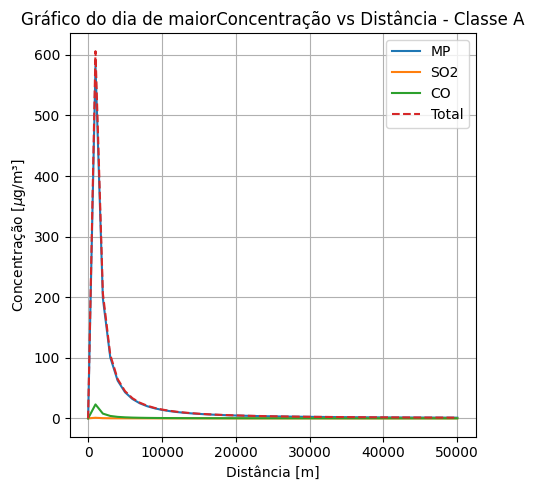

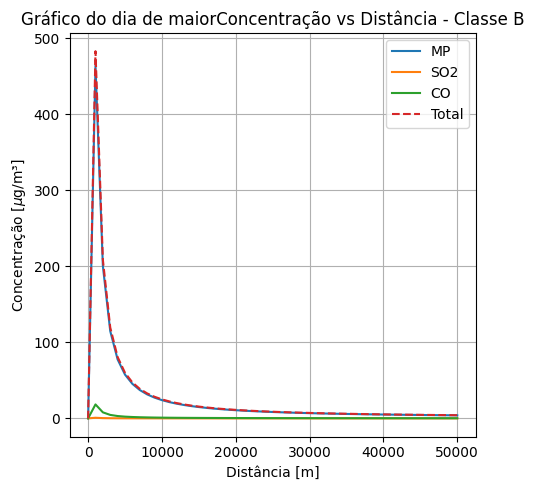

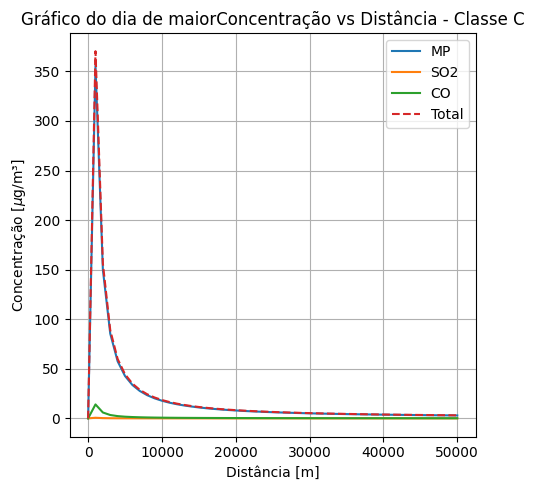

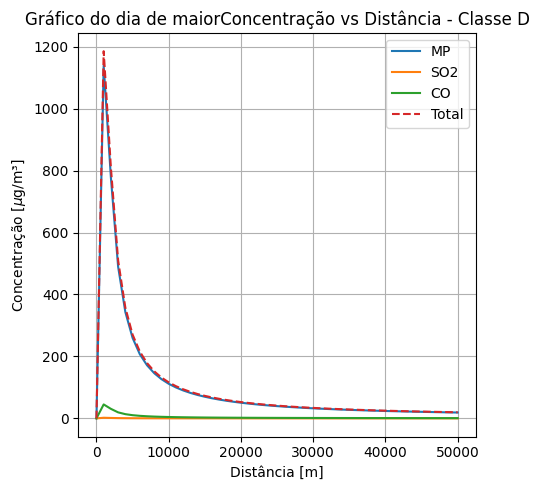

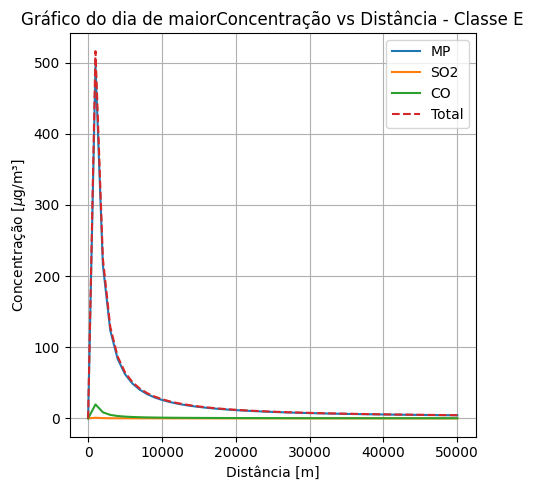

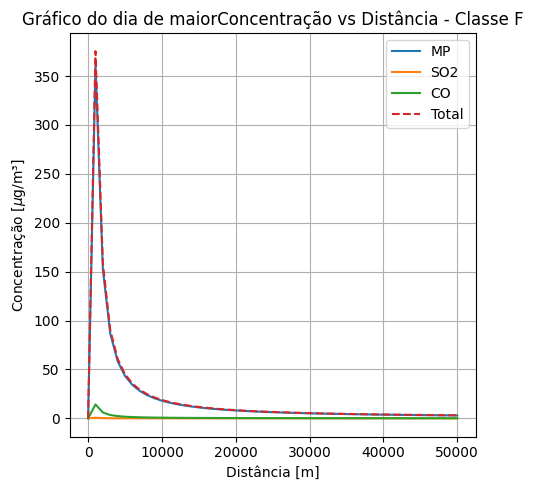

In [283]:
# Criando gráficos separados para cada classe com os três poluentes

# Definindo uma lista de dataframes e seus respectivos rótulos
dfs = [df_Amax, df_Bmax, df_Cmax, df_Dmax, df_Emax, df_Fmax]
labels = ['Classe A', 'Classe B', 'Classe C', 'Classe D', 'Classe E', 'Classe F']

# Plotando cada dataframe em um gráfico separado
for df, label in zip(dfs, labels):
    plt.figure(figsize=(5, 5))  # Tamanho da figura
    
    # Plotando as três linhas para MP, SO2 e CO
    plt.plot(df['x'], df['MP'], label='MP')
    plt.plot(df['x'], df['SO2'], label='SO2')
    plt.plot(df['x'], df['CO'], label='CO')
    plt.plot(df['x'], df['Total'], label='Total', linestyle='--')
    
    # Adicionar legendas e rótulos dos eixos
    plt.legend()  # Mostrar legenda com base nos labels
    plt.xlabel('Distância [m]')  # Rótulo do eixo x
    plt.ylabel('Concentração [$\mu$g/m³]')  # Rótulo do eixo y
    plt.title(f'Gráfico do dia de maiorConcentração vs Distância - {label}')  # Título do gráfico
    plt.grid(True)  # Adicionar grade
    plt.tight_layout()  # Ajustar layout
    plt.show()

In [ ]:
# Criando dominio de modelagem
x = np.linspace(-100,10000,500)
# print(x)
y = np.linspace(-10000,10000,500)

# Criando matrizes de x e y
xx,yy = np.meshgrid(x,y)
#print(xx.shape)




In [ ]:
# Adotando inputs
classe = 'F'
urbOrRural = 'urbano' 
hg = 150 # m altura geométrica da chaminé
qs = 100 # g/s
u = 5 # m/s
y = 0 # estimando na direção do vento
z = 1.5 # altura do nariz
d = 1 # em metros
vs = 10 # em m/s
Ts = 300 # em Kelvin
Tamb = 293 # em Kelvin


sigmaY, sigmaZ = sigmaYZ(xx, classe, urbOrRural)


if vs>1.5*u:
    # Estimando a sobrelevação da pluma (deltaH)
    deltaH = deltaHBriggs(d,vs,Ts,Tamb,classe,u)
    print('deltaH = '+str(deltaH))
    hef = hg+deltaH
    print('A pluma subiu')
else:
    hef = hg +2*d*((vs/u)-1.5)
    print('A pluma caiu')

# Utilizando a matriz de yy como input na função do modelo gaussiano
conc = modeloGaussiano(qs,sigmaY,sigmaZ,u,yy,z,H)

# Visualização dos resultados no espaço
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
fig,ax = plt.subplots()
ax.contourf(xx,yy,conc+0.1,norm = LogNorm())

# Corte em y - sobre o eixo x
fig,ax = plt.subplots()
ax.plot(x,conc[250,:])

# Corte em x - sobre o eixo y 
fig,ax = plt.subplots()
ax.plot(x,conc[:,100])